# PROBLEM STATEMENT

Data assimilation are numerical methods used in geosciences to mix the information of observations (noted as $y$) and a dynamical model (noted as $f$) in order to estimate the true/hidden state of the system (noted as $x$) at every time step $k$. Usually, they are related following a nonlinear state-space model:
\begin{align}
  x_k & = f_{k-1,k}(x_{k-1}) + \eta_k\\
  y_k & = H x_k + \epsilon_k
\end{align}
with $\eta$ and $\epsilon$ some independant white Gaussian noises respectively respresenting the model forecast error and the error of observation. Specification and tuning of these errors are important issues in data assimilation. In this Python library, we propose an iterative expectation-maximisation (EM) algorithm to estimate the corresponding model error covariances, noted as $Q$ for the dynamical model and $R$ for the observations. 

EM algorithm is compared with lag-innovation based algorithm

This Python library is attached to the publication "Estimating model error covariances in nonlinear state-space models using Kalman smoothing and the expectation-maximisation algorithm", from **D. Dreano, P. Tandeo, M. Pulido, B. Ait-El-Fquih, T. Chonavel and I. Hoteit**, submitted to the *Quarterly Journal of the Royal Meteorological Society*. If you use this library, please do not forget to cite our work.

# IMPORT MODULES

Here, we import the different Python libraries and modules. Concerning the dynamical models, we provide two different implementations: a slow procedure in Python and a fast procedure in Fortran. In order to use the Fortran version, you need to compile the f90 files in the "models" folder ("l63_for.f90" and "l96_for.f90") using the command "f2py". You also need to download the "tqdm" library to display the progress bar (available at http://github.com/tqdm/).

In [558]:
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# numpy, matplotib and others
import numpy as np
from numpy.random import RandomState
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import os
import pickle
from IPython.core.debugger import Tracer
from tqdm import tqdm

# L63 and L96 models using python (slow)
from models.L63 import l63_predict, l63_jac
from models.L96 import l96_predict, l96_f, l96_jac

# data assimilation routines
from algos.utils import climat_background, RMSE, gen_truth, gen_obs

# for EM algorithm
from algos.EM_EKS import EKS, EM_EKS

Populating the interactive namespace from numpy and matplotlib


# TEST ON LORENZ-63

To begin, as dynamical model $f$, we choose the Lorenz-63 chaotic system. This low-dimensional model is classicaly used in data assimilation and it is the one used in the publication by Dreano et al. cited below. We generate data using $Q=0.05 I_{3\times3}$ and $R=2 I_{3\times3}$. Then, we try to estimate these covariance matrices using the EM algorithm and two Kalman smoother procedures.

In [559]:
### GENERATE SIMULATED DATA (LORENZ-63 MODEL)
def gen_L63(Q,R,T):
    # random number generator
    prng = RandomState(10)

    # dynamical model
    Nx = 3 # dimension of the state
    dt = .01 # integration time
    sigma = 10;rho = 28;beta = 8./3 # physical parameters
    f = lambda x: l63_predict(x, dt, sigma, rho, beta) # python version (slow)
    #fmdl=mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy=dt)
    #f = lambda x: fmdl.integ(x) # fortran version (fast)
    jacF = lambda x: l63_jac(x, dt, sigma, rho, beta) # python version (slow)

    # observation operator
    No = 3 # dimension of the observations
    h = lambda x: x
    jacH = lambda x: np.eye(Nx)
    H = np.eye(Nx)

    # background state
    x0_true = np.r_[6.39435776, 9.23172442, 19.15323224]
    xb, B = climat_background(f, x0_true, 5000)

    # size of the sequence
    #T = 5000 # 10 Lorenz-63 times  --> parameter setting
    time = range(T)*array([dt])

    # generate state
    Q_true = np.eye(Nx) * Q         #--> parameter setting
    X_true = gen_truth(f, x0_true, T, Q_true, prng)

    # generate observations
    dt_obs = 1 # 1 observation every dt_obs time steps
    R_true = np.eye(No) * R         #--> parameter setting
    Yo = gen_obs(h, X_true, R_true, dt_obs, prng)
    
    return time, X_true,Yo, Q_true, R_true, jacF, jacH, f,h,xb,B

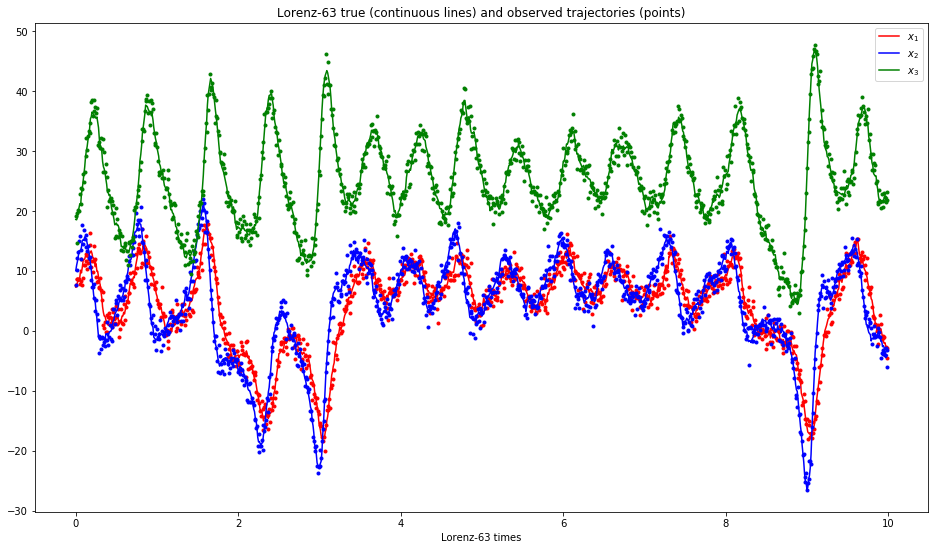

In [560]:
T = 1000
Nx = 3
No = 3
time, X_true,Yo, Q_true, R_true, jacF, jacH, f,h,xb,B = gen_L63(0.2,2,T)
### PLOT STATE AND OBSERVATIONS

line1,=plt.plot(time,X_true[0,1:T+1],'-r');plt.plot(time,Yo[0,:],'.r')
line2,=plt.plot(time,X_true[1,1:T+1],'-b');plt.plot(time,Yo[1,:],'.b')
line3,=plt.plot(time,X_true[2,1:T+1],'-g');plt.plot(time,Yo[2,:],'.g')
plt.title('Lorenz-63 true (continuous lines) and observed trajectories (points)')
plt.xlabel('Lorenz-63 times')
plt.legend([line1, line2, line3], ['$x_1$', '$x_2$', '$x_3$'])

In [578]:
### KALMAN FILTER

def _EKF(Nx, No, T, xb, B, Q, R, Yo, f, jacF, h, jacH, alpha, delta, Q_filt, R_filt):
   
# Kalman filter              
    Xa = np.zeros((Nx, T+1))
    Xf = np.zeros((Nx, T))
    Pa = np.zeros((Nx, Nx, T+1))
    Pf = np.zeros((Nx, Nx, T))
    F_all = np.zeros((Nx, Nx, T))
    H_all = np.zeros((No, Nx, T))
    K_all = np.zeros((Nx, No, T+1))
    d_all = np.zeros((No, T))
    da_all = np.zeros((No, T))
    
    x = xb; Xa[:,0] = x
    P = B; Pa[:,:,0] = P

    for t in range(T):
    # Forecast
        F = jacF(x)
        x = f(x)                    # Paper --> xf(k+1) = F(k)xa(k)
        P = F.dot(P).dot(F.T) + Q   # Paper --> Pf(k_1) = F(k)Pa(k)HT(k+1)+Qfilt(k)
#         P = .5*(P + P.T)            # Not in the Paper --> ???averaging???

        Pf[:,:,t]=P; Xf[:,t]=x; F_all[:,:,t]=F  # assigning to time sampled variables in paper t --> t+1

    # Update
        if not np.isnan(Yo[0,t]):
            H = jacH(x)                        # linear function of y update
            d = Yo[:,t] - h(x)                 # Paper --> y(k+1) - yf(k+1)
            S = H.dot(P).dot(H.T) + R          # Paper --> Py(k+1) = H(k+1)Pf(k+1)HT(k+1) + Rfilt(k)
            K = P.dot(H.T).dot(inv(S))         # Paper --> K(k+1) = Pf(k+1)HT(k+1)(Py(k+1))^-1
            P = (np.eye(Nx) - K.dot(H)).dot(P) # Paper --> Pa(k+1) = (I-K(k+1)H(k+1))Pf(k+1)
            x = x + K.dot(d)                   # Paper --> xa(k+1) = x(f)(k+1) + K(k+1)(innovation)
            da = Yo[:,t] - h(x)
        Pa[:,:,t]=P; Xa[:,t]=x; H_all[:,:,t]=H
        d_all[:,t]=d; da_all[:,t]=da; K_all[:,:,t]=K
        
        
        Qe_all = np.zeros((Nx, Nx, T))
        Re_all = np.zeros((No, No, T))
        if t is not 0:

            Pe_1 = inv(F_all[:,:,t]).dot(inv(H_all[:,:,t]))
            Pe_1a = np.outer(d_all[:,t],d_all[:,t-1])

            Pe_2 = K_all[:,:,t-1].dot(np.outer(d_all[:,t-1],d_all[:,t-1])).dot(inv(H_all[:,:,t-1]).T)
            Pe = Pe_1.dot(Pe_1a).dot(inv(H_all[:,:,t-1].T)) + Pe_2


            Qe = Pe - F_all[:,:,t-1].dot(Pa[:,:,t-1]).dot(F_all[:,:,t-1].T)

            Re = np.outer(d_all[:,t],d_all[:,t]) - H_all[:,:,t-1].dot(Pf[:,:,t-1]).dot(inv(H_all[:,:,t-1]).T)

            Qe_all[:,:,t] = Qe
            Re_all[:,:,t] = Re
            

            Q_filt[:,:,t] = Q_filt[:,:,t-1] + delta*(Qe-Q_filt[:,:,t-1])
            R_filt[:,:,t] = R_filt[:,:,t-1] + delta*(Re-R_filt[:,:,t-1])
            
            Q = Q_filt[:,:,t]
            R = R_filt[:,:,t]
        

    
        
#     Q_filt = np.zeros((Nx, Nx, T))
#     R_filt = np.zeros((No, No, T))

# Algorithm implementation    
    # params for innovation statistics
    temp = 0
    sigma = np.zeros((T))
    sigma_filt =  np.zeros((T))
    lamb = np.zeros((T))
    lamb_filt =  np.zeros((T))
    
#     for t in range(1,T-1):

#         Pe_1 = inv(F_all[:,:,t]).dot(inv(H_all[:,:,t]))
#         Pe_1a = np.outer(d_all[:,t],d_all[:,t-1])
        
#         Pe_2 = K_all[:,:,t-1].dot(np.outer(d_all[:,t-1],d_all[:,t-1])).dot(inv(H_all[:,:,t-1]).T)
#         Pe = Pe_1.dot(Pe_1a).dot(inv(H_all[:,:,t-1].T)) + Pe_2
        
        
#         Qe = Pe - F_all[:,:,t-1].dot(Pa[:,:,t-1]).dot(F_all[:,:,t-1].T)
        
#         Re = np.outer(d_all[:,t],d_all[:,t]) - H_all[:,:,t-1].dot(Pf[:,:,t-1]).dot(inv(H_all[:,:,t-1]).T)

#         Qe_all[:,:,t] = Qe
#         Re_all[:,:,t] = Re
        
#         Q_filt[:,:,t] = Q_filt[:,:,t-1] + delta*(Qe-Q_filt[:,:,t-1])
#         R_filt[:,:,t] = R_filt[:,:,t-1] + delta*(Re-R_filt[:,:,t-1])
        
        
        # Other method -- innovation statistics
#         temp = temp + np.dot(d_all[:,t],d_all[:,t])
#         sigma[t] = np.dot(d_all[:,t],d_all[:,t])/No/No*2
#         lamb[t] = (np.dot(d_all[:,t],d_all[:,t])/No - sigma[t]*No)/np.trace(H_all[:,:,t].dot(Pf[:,:,t]).dot(H_all[:,:,t].T))
        
#         sigma_filt[t] = sigma_filt[t-1] + delta*(sigma[t-1]-sigma_filt[t-1])
#         lamb_filt[t] = sigma_filt[t-1] + delta*(sigma[t-1]-sigma_filt[t-1])
                     
# Observation : different indexing -- result the same (more)
    
    res = {
          'analysis_states'            : Xa,
          'analysis_covariance'        : Pa,
          'forecast_states'            : Xf,
          'forecast_covariance'        : Pf,
          'state_linearisation'        : F_all,
          'forecast_linearisation'     : H_all,
          'kalman_gain'                : K_all,
          'model_noise_covariance'     : Qe_all,
          'observarion_covariance'     : Re_all,
          'model_noise_covariance_filt': Q_filt,
          'observarion_covariance_filt': R_filt
        }
    
    return res

100%|██████████| 8/8 [00:32<00:00,  4.00s/it]


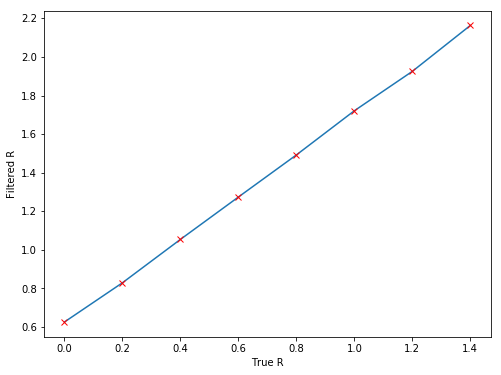

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


1.0983954121158739 0.6167967487399896


In [562]:
# block to get linear dependancies:
Q = 0.2
R = 3.0
T = 10000
delta = 1/2000
Q_filt_init = np.zeros((Nx, Nx, T))
R_filt_init = np.zeros((No, No, T))

Q_init = np.eye(Nx)
R_init = np.eye(No)

Q_x = []
Q_y = []

R_x = []
R_y = []

for i in tqdm(range(0,15,2)):
    Q = i/10
    time, X_true,Yo, Q_true, R_true, jacF, jacH, f,h,xb,B = gen_L63(Q,R,T)
    res_EKF = _EKF(Nx, No, T, xb, B, Q_init, R_init, Yo, f, jacF, h, jacH, 1,delta, Q_filt_init, R_filt_init)
    Q_filt = res_EKF['model_noise_covariance_filt']
    R_filt = res_EKF['observarion_covariance_filt']
    R_x.append(trace(R_true)/No)
    R_y.append(trace(R_filt[:,:,-1])/No)
    Q_x.append(trace(Q_true)/Nx)
    Q_y.append(trace(Q_filt[:,:,-1])/Nx)

#     print(R_filt[:,:,-2])
    
x = np.array(Q_x)
y = np.array(Q_y)

plt.figure(figsize=(8, 6))
plt.plot(x,y)
plt.plot(x,y,'rx')
# plt.title('Dependency between real and resulting matrix R')
plt.xlabel('True R')
plt.ylabel('Filtered R')
plt.savefig('1.png')
plt.show()
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]
print(m,c)

In [587]:
### INITIALIZE THE ALGORITHMS

N_iter = 1
Q_init = np.eye(Nx)
R_init = np.eye(No)

# initializing model
Q = 0.2
R = 3.0
T = 5000
time, X_true,Yo, Q_true, R_true, jacF, jacH, f,h,xb,B = gen_L63(Q,R,T)
print(R_true)

[[3. 0. 0.]
 [0. 3. 0.]
 [0. 0. 3.]]


In [588]:
### APPLY THE EM ALGORITHM ON EXTENDED KALMAN SMOOTHER (EM-EKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full',
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'inflation_factor'                         : 1 }

# function
res_EM_EKS = EM_EKS(params)

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


In [589]:
### APPLY THE LAG-INNOVATION BASED ALGORITHM ON KALMAN FILTER


delta = 1/200
Q_filt_init = np.zeros((Nx, Nx, T))
R_filt_init = np.zeros((No, No, T))
Q_lag = np.zeros((Nx, Nx, N_iter))
R_lag = np.zeros((No, No, N_iter))

# res_EKF = _EKF(Nx, No, T, xb, B, Q_init, R_init, Yo, f, jacF, h, jacH, 1,delta, Q_filt_init, R_filt_init)
for i in tqdm(range(N_iter)):
    res_EKF = _EKF(Nx, No, T, xb, B, Q_init, R_init, Yo, f, jacF, h, jacH, 1,delta, Q_filt_init, R_filt_init)
    Q_filt = res_EKF['model_noise_covariance_filt']
    R_filt = res_EKF['observarion_covariance_filt']
    Q_filt_init[:,:,0] = Q_filt[:,:,-1]
    R_filt_init[:,:,0] = R_filt[:,:,-1]
    Q_lag[:,:,i] = Q_filt[:,:,-1]
    R_lag[:,:,i] = R_filt[:,:,-1]

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Text(0.5,0,'Lorenz-63 times')

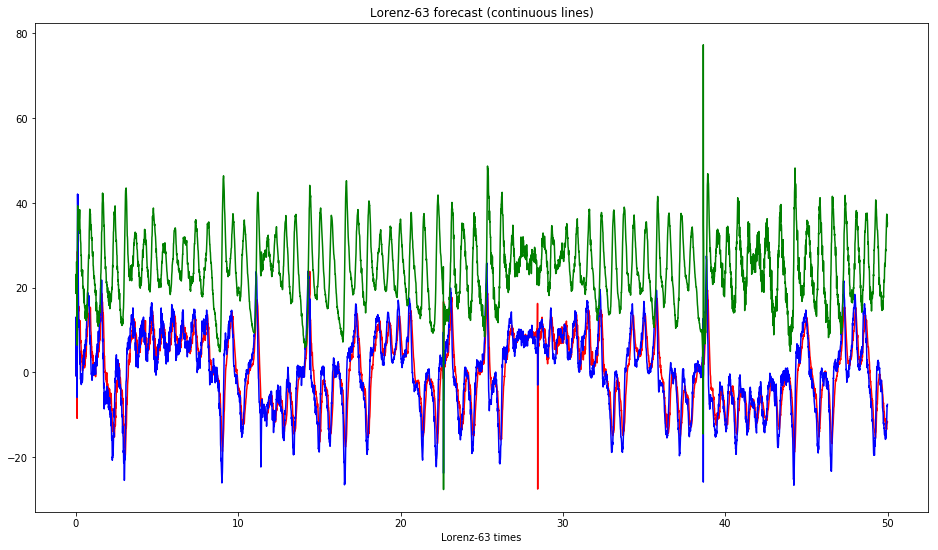

In [590]:
Xf = res_EKF['forecast_states']

line1=plt.plot(time[:T],Xf[0,:],'-r')
line2=plt.plot(time[:T],Xf[1,:],'-b')
line3=plt.plot(time[:T],Xf[2,:],'-g')
plt.title('Lorenz-63 forecast (continuous lines)')
plt.xlabel('Lorenz-63 times')
#plt.legend([line1, line2, line3], ['$x_1$', '$x_2$', '$x_3$'])

# Printing the results 1
Printing the results just for last iteration

[[3. 0. 0.]
 [0. 3. 0.]
 [0. 0. 3.]]


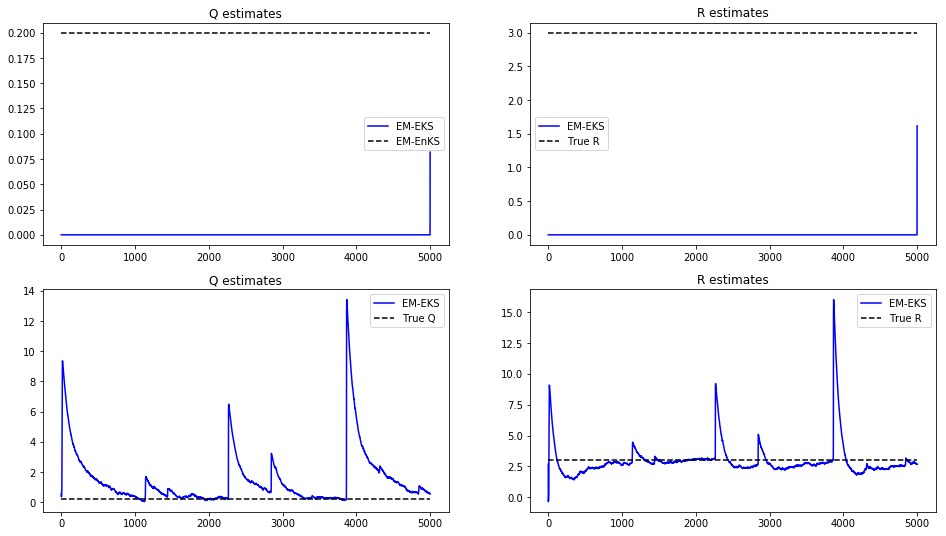

In [591]:
### COMPARE RESULTS BETWEEN THE TWO STRATEGIES (EM-EKS AND EM-EnKS)
# extract outputs
Q_e = res_EKF['model_noise_covariance']
R_e = res_EKF['observarion_covariance']
print(R_true)

Q_filt = res_EKF['model_noise_covariance_filt']
R_filt = res_EKF['observarion_covariance_filt']
#R_true = R_true*m+c
# plot trace of Q
plt.subplot(2,2,1)
line1,=plt.plot(np.trace(Q_e)/Nx,'b')
line3,=plt.plot((1,T),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line3], ['EM-EKS', 'EM-EnKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,2)
line1,=plt.plot(np.trace(R_e)/No,'b')
line3,=plt.plot((1,T),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line3], ['EM-EKS', 'True R'])


# plot trace of Q
plt.subplot(2,2,3)
line1,=plt.plot(np.trace(Q_filt)/Nx,'b')
line3,=plt.plot((1,T),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line3], ['EM-EKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,4)
line1,=plt.plot((np.trace(R_filt)/No),'b')
line3,=plt.plot((1,T),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line3], ['EM-EKS', 'True R'])



# Comparing methods

2.7471244930204217


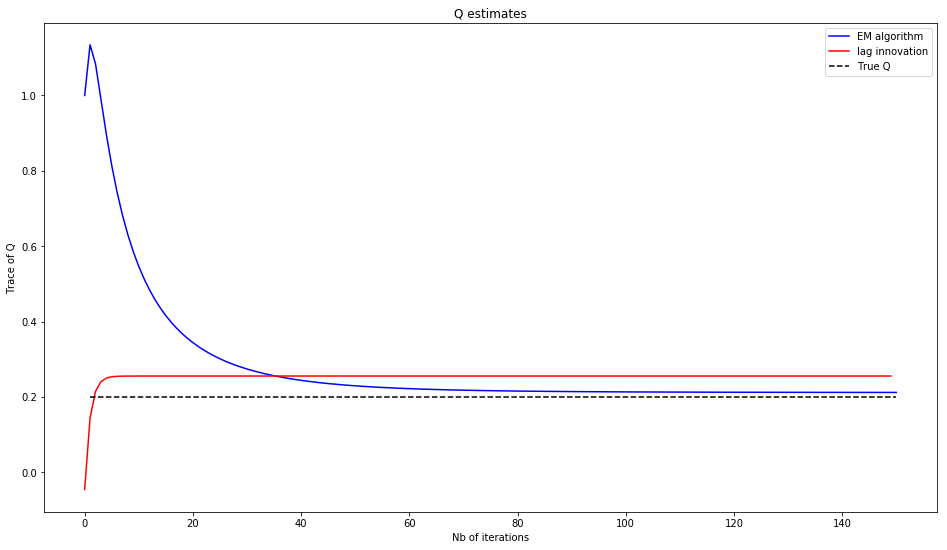

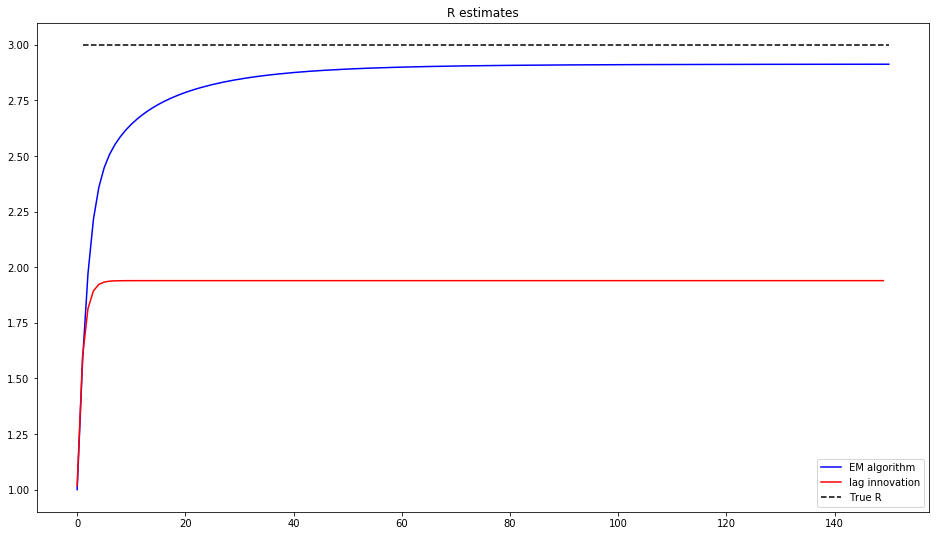

In [531]:
### COMPARE RESULTS BETWEEN THE TWO STRATEGIES (EM-EKS AND EM-EnKS)

# extract outputs
Q_EKS = res_EM_EKS['EM_model_noise_covariance']
R_EKS = res_EM_EKS['EM_observation_noise_covariance']
# RMSE_EKS=res_EM_EKS['RMSE']
# RMSE_EnKS=res_EM_EnKS['RMSE']
# plot trace of Q
plt.figure()
line1,=plt.plot(np.trace(Q_EKS)/Nx,'b')
#line2,=plt.plot((np.trace(Q_lag)/Nx),'r')
line2,=plt.plot((np.trace(Q_lag)/Nx-c)/m,'r')
line3,=plt.plot((1,N_iter),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line2, line3], ['EM algorithm', 'lag innovation', 'True Q'])
plt.xlabel("Nb of iterations")
plt.ylabel("Trace of Q")
plt.savefig("4.png")

# plot trace of R
print(np.trace(R_lag[:,:,-1])/No)
plt.figure()
line1,=plt.plot(np.trace(R_EKS)/No,'b')
#line2,=plt.plot(np.trace(R_lag)/No,'r')
line3,=plt.plot((1,N_iter),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
line2,=plt.plot(((np.trace(R_lag)/No)-c)/m,'r')
plt.title('R estimates')
plt.legend([line1, line2, line3], ['EM algorithm', 'lag innovation', 'True R'])
plt.savefig("2.png")
# plot log-likelihood
# plt.subplot(2,2,3)
# line1,=plt.plot(loglik_EKS,'b')
# line2,=plt.plot(loglik_EnKS,'r')
# plt.title('Log-likelihood')
# plt.legend([line1, line2], ['EM-EKS', 'EM-EnKS'])

# # plot Root Mean Square Error
# plt.subplot(2,2,4)
# line1,=plt.plot(RMSE_EKS,'b')
# line2,=plt.plot(RMSE_EnKS,'r')
# plt.title('RMSE')
# plt.legend([line1, line2], ['EM-EKS', 'EM-EnKS'])

In [547]:
### GENERATE SIMULATED DATA (LORENZ 96 MODEL)

# random number generator
prng = RandomState(1)

# dynamical model
Nx = 40 # dimension of the state
dt = .05 # integration time
F = 8 # physical parameter
f = lambda x: l96_predict(x,dt,F) # python version (slow)
#jacF = lambda x: l63_jac(x, dt, sigma, rho, beta) # python version (slow)
jacF = lambda x: l96_jac(x, dt) # python version (slow)

# observation operator
No = 40 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = np.eye(Nx)

# background state
x0_true = array(zeros(Nx))
xb, B = climat_background(f, x0_true, 5000)

# size of the sequence
T = 5000 # 20 Lorenz-96 times
time = range(T+1)*array([dt])

# generate state
Q_true = np.eye(Nx) * 0.2
X_true = gen_truth(f, x0_true, T+50, Q_true, prng)

# generate observations
dt_obs = 1 # 1 observation every dt_obs time steps
R_true = np.eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
X_true = X_true[:,50:T+50+1]
Yo = Yo[:,50:T+50+1]

Text(0.5,1,'Observed trajectories')

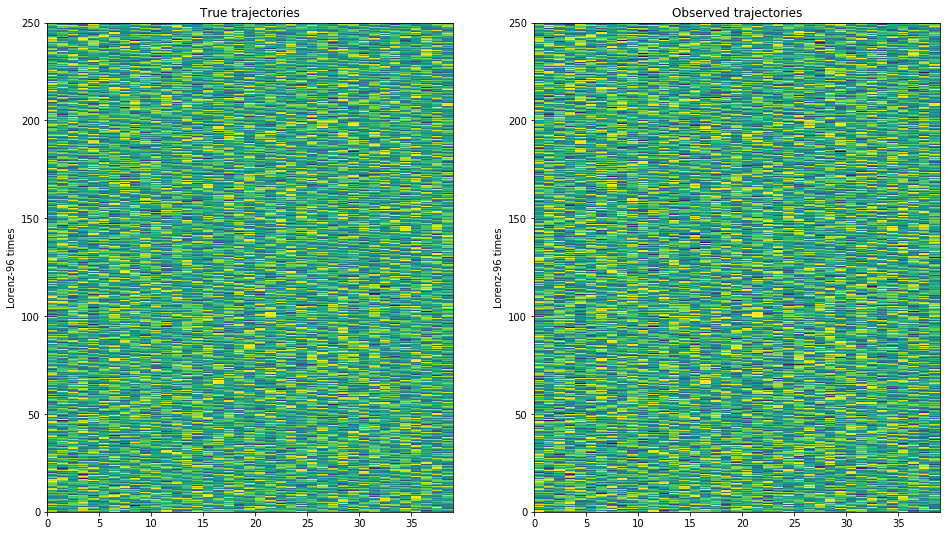

In [548]:
### PLOT STATE AND OBSERVATIONS

[X,Y]=meshgrid(range(Nx),time)
subplot(1,2,1);pcolor(X,Y,X_true.T);xlim([0,Nx-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('True trajectories')
subplot(1,2,2);pcolor(X,Y,ma.masked_where(isnan(Yo.T),Yo.T));xlim([0,Nx-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('Observed trajectories')

In [549]:
### APPLY THE EM ALGORITHM ON ENSEMBLE KALMAN SMOOTHER (EM-EnKS)

# EM parameters
N_iter = 1
Q_init = np.eye(Nx)
R_init = np.eye(No)
N = 10 # number of members

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'observation_matrix'                       : H,
           'observations'                             : Yo,
           'nb_particles'                             : N,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full',
           #'model_noise_covariance_matrix_template'   : np.eye(Nx) # only for constant model noise covariance
         }

# function

# res_EKF_96 = _EKF(Nx, No, T, xb, B, Q_init, R_init, Yo, f, jacF, h, jacH, 1)


delta = 1/500
Q_filt_init = np.zeros((Nx, Nx, T-1))
R_filt_init = np.zeros((No, No, T-1))
Q_lag = np.zeros((Nx, Nx, N_iter))
R_lag = np.zeros((No, No, N_iter))

# res_EKF = _EKF(Nx, No, T, xb, B, Q_init, R_init, Yo, f, jacF, h, jacH, 1,delta, Q_filt_init, R_filt_init)
for i in tqdm(range(N_iter)):
    res_EKF_96 = _EKF(Nx, No, T, xb, B, Q_init, R_init, Yo, f, jacF, h, jacH, 1,delta, Q_filt_init, R_filt_init)
    Q_filt = res_EKF_96['model_noise_covariance_filt']
    R_filt = res_EKF_96['observarion_covariance_filt']
    Q_filt_init[:,:,0] = Q_filt[:,:,-1]
    R_filt_init[:,:,0] = R_filt[:,:,-1]
    Q_lag[:,:,i] = Q_filt[:,:,-1]
    R_lag[:,:,i] = R_filt[:,:,-1]


100%|██████████| 1/1 [00:24<00:00, 24.50s/it]


In [550]:
### APPLY THE EM ALGORITHM ON ENSEMBLE KALMAN SMOOTHER (EM-EnKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'observation_matrix'                       : H,
           'observations'                             : Yo,
           'nb_particles'                             : N,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full',
           #'model_noise_covariance_matrix_template'   : np.eye(Nx) # only for constant model noise covariance
         }

# function

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full',
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'inflation_factor'                         : 1 }

# function
res_EM_EKS = EM_EKS(params)


100%|██████████| 1/1 [00:34<00:00, 34.21s/it]


# Results for Lorenz-96 model

blabla ball

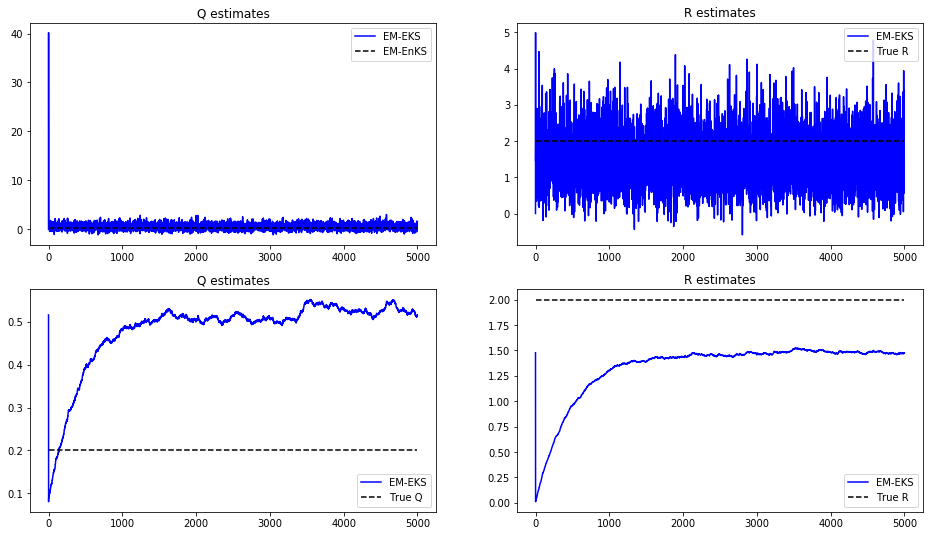

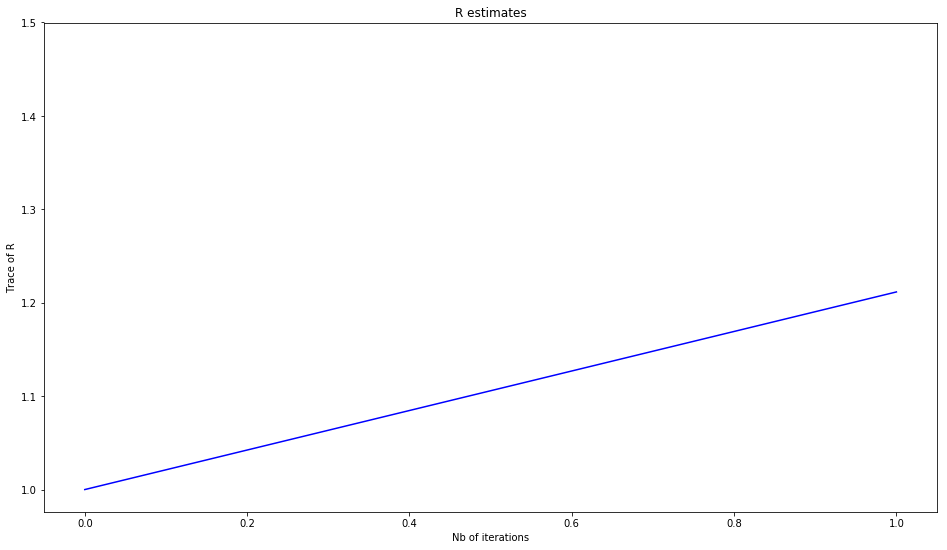

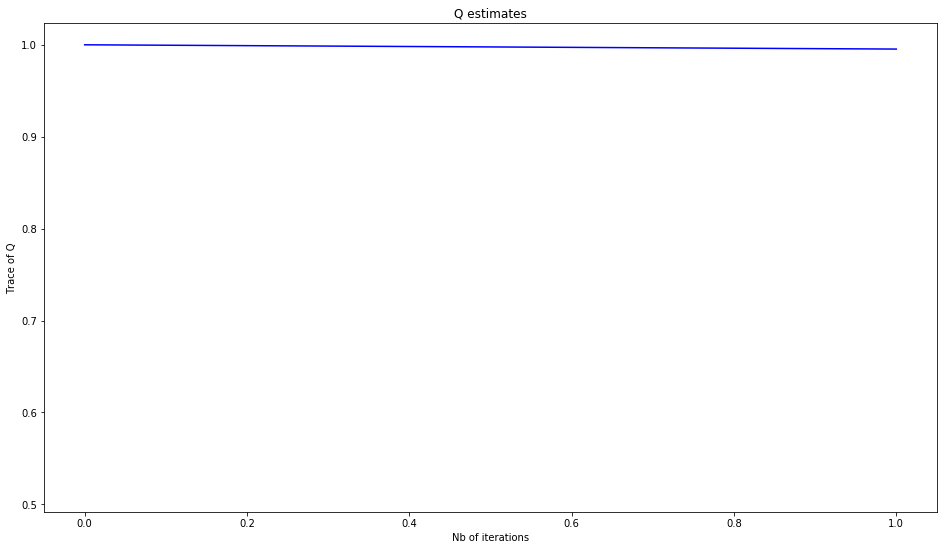

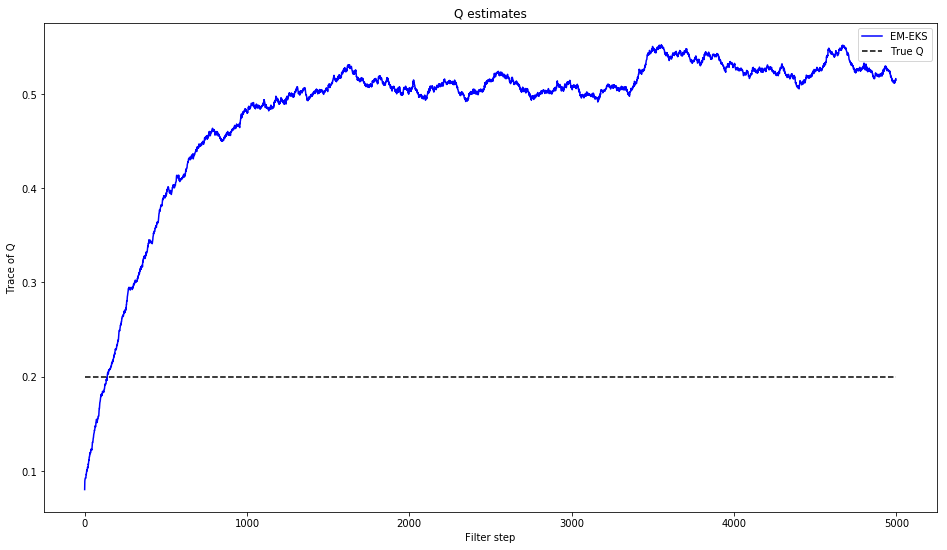

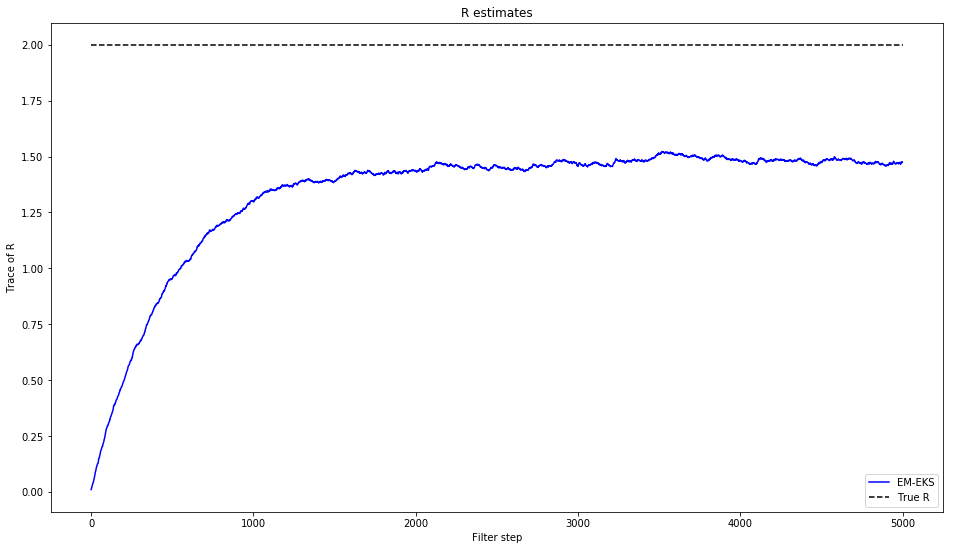

In [555]:
### COMPARE RESULTS BETWEEN THE TWO STRATEGIES (EM-EKS AND EM-EnKS)

# extract outputs
Q_e = res_EKF_96['model_noise_covariance']
R_e = res_EKF_96['observarion_covariance']
Q_EnKS = res_EM_EKS['EM_model_noise_covariance']
R_EnKS = res_EM_EKS['EM_observation_noise_covariance']


Q_filt = res_EKF_96['model_noise_covariance_filt']
R_filt = res_EKF_96['observarion_covariance_filt']

# plot trace of Q
plt.subplot(2,2,1)
line1,=plt.plot(np.trace(Q_e)/Nx,'b')
line3,=plt.plot((1,T),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line3], ['EM-EKS', 'EM-EnKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,2)
line1,=plt.plot(np.trace(R_e)/No,'b')
line3,=plt.plot((1,T),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line3], ['EM-EKS', 'True R'])


# plot trace of Q
plt.subplot(2,2,3)
line1,=plt.plot(np.trace(Q_filt)/Nx,'b')
line3,=plt.plot((1,T),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line3], ['EM-EKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,4)
line1,=plt.plot(np.trace(R_filt)/No,'b')
line3,=plt.plot((1,T),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line3], ['EM-EKS', 'True R'])

plt.figure()
line2,=plt.plot(np.trace(R_lag)/No,'r')
line1,=plt.plot(np.trace(R_EnKS)/No,'b')
plt.title("R estimates")
plt.xlabel("Nb of iterations")
plt.ylabel("Trace of R")
plt.savefig("3.png")
plt.show()

plt.figure()
line2,=plt.plot(((np.trace(Q_lag)/Nx)),'r')
line1,=plt.plot(np.trace(Q_EnKS)/Nx,'b')
plt.title("Q estimates")
plt.xlabel("Nb of iterations")
plt.ylabel("Trace of Q")
plt.savefig("5.png")
plt.show()

# plot trace of Q
plt.figure()
line1,=plt.plot(np.trace(Q_filt[:,:,1:])/Nx,'b')
line3,=plt.plot((1,T),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line3], ['EM-EKS', 'True Q'])
plt.xlabel("Filter step")
plt.ylabel("Trace of Q")
plt.savefig("6.png")

# plot trace of R
plt.figure()
line1,=plt.plot(np.trace(R_filt[:,:,1:])/No,'b')
line3,=plt.plot((1,T),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line3], ['EM-EKS', 'True R'])
plt.xlabel("Filter step")
plt.ylabel("Trace of R")
plt.savefig("7.png")


In [537]:
# np.set_printoptions(threshold=np.nan)
# #print(Q_filt[:,:,-10])
# import cv2
# cv2.namedWindow('image',cv2.WINDOW_NORMAL)
# cv2.resizeWindow('image', 1000,1000)
# #for i in range(T):
#     #cv2.imshow('image',Q_filt[:,:,i])
#     #cv2.waitKey(1)
# cv2.destroyAllWindows()

In [ ]:
# print(T)
# for i in range(1,T,200):
#     print(i)
    
#     plt.figure(figsize = (15,5))
    
#     plt.subplot(131)
#     plt.imshow(Q_filt[:,:,i])
#     plt.xlabel('Q_filt')

    
#     plt.subplot(132)
#     plt.imshow(Q_true)
#     plt.xlabel('Q_true')

#     plt.subplot(133)
#     plt.imshow(np.absolute(np.subtract(Q_filt[:,:,i],Q_true)))
#     plt.xlabel('Q_filt - Q_true')
#     plt.show()